In [31]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import re
import astropy.units as u
from scipy.ndimage import gaussian_filter

from tqdm import tqdm_notebook as tqdm
from scipy import signal
import arepo
import matplotlib as mpl
import scipy.stats as st

from numpy.polynomial import Polynomial

from scipy.stats import linregress

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5', 'Nbody300-BH', 'Nbody500-BH1E8']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [134]:
fourier_S = read_fourier(1, lvl='lvl2')
bangle = np.arctan2(fourier_S['snapshot_300']['A2i'][5], fourier_S['snapshot_300']['A2r'][5])

In [135]:
sn = read_snap(300, 1, lvl='lvl2', parttype=[2, 4])

Exception: could not detect backend for file '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/Nbody/lvl2/output', snapshot 300, filenum None. Specify file format or check file name.

In [136]:
snap = 300

fourier_S = read_fourier(1, lvl='lvl2')
snap_key = 'snapshot_'+str(snap).zfill(3)
bangle = np.arctan2(fourier_S[snap_key]['A2i'][5], fourier_S[snap_key]['A2r'][5])

OSError: Unable to open file (unable to open file: name = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis//fourier_component/data/fourier_phantom-vacuum-Sg20-Rc3.5-lvl2.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [110]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [111]:
# sun_angle = 20. * (np.pi / 180.)
bangle = 22. * (np.pi / 180.) + sun_angle # snap 300
# bangle = -30. * ( np.pi / 180.) + sun_angle # snap 000
# bangle = 50. * ( np.pi / 180.) + sun_angle # snap 050

In [118]:
disk_pos = sn.part2.pos.value - center
disk_pos = np.concatenate((disk_pos, sn.part4.pos.value - center))
disk_pos = rotate_pos(disk_pos, -bangle)

disk_vel = sn.part2.vel.value
disk_vel = np.concatenate((disk_vel, sn.part4.vel.value))
disk_vel = rotate_pos(disk_vel, -bangle)

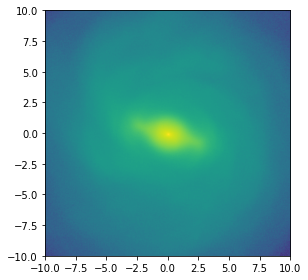

In [119]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
center = np.array([200., 200., 200.])

x = disk_pos[:,0]
y = disk_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [120]:
disk_R = np.linalg.norm(disk_pos[:,:2], axis=1)

phi = np.arctan2(y, x)

vR = disk_vel[:,0] * np.cos(phi) - disk_vel[:,1] * np.sin(phi)
vphi = disk_vel[:,0] * np.sin(phi) + disk_vel[:,1] * np.cos(phi)


In [154]:
sun_pos = np.array([8.2 * (40/35), 0.0, 0.0])
rdiff = np.linalg.norm(disk_pos - sun_pos, axis=1)
key = rdiff < 0.3

In [155]:
print(np.median(vphi[key]))

244.94827192002253


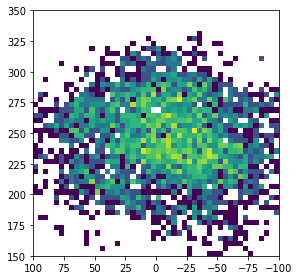

In [156]:
nres = 48

range_xy = [[-100, 100], [150, 350]]

x = vR[key]
y = vphi[key]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

heatmap_xy = gaussian_filter(heatmap_xy, 0.)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
ax.invert_xaxis()
fig.tight_layout()

plt.show()


In [157]:
keyR = rdiff < 0.3
key = np.logical_and(np.logical_and(keyR, vphi > 100), vphi < 210)
poskey = np.logical_and(key, vR>0)
negkey = np.logical_and(key, vR<0)

Npos = len(np.where(poskey)[0])
Nneg = len(np.where(negkey)[0])

print(Npos, Nneg)

B = (Npos-Nneg)/(Npos+Nneg)
print(B)

250 364
-0.18566775244299674


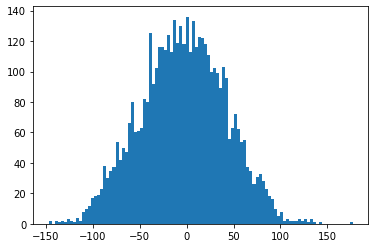

In [153]:
plt.hist(vR[key], bins=100);

In [ ]:
star_pos = sn.part4.pos.value - center
disk_pos = sn.part2.pos.value - center

star_pos = rotate_pos(star_pos, -bangle)
disk_pos = rotate_pos(disk_pos, -bangle)




In [159]:
0.028 * (7.5E3/2333.3333)**(1/3)

0.041322462362633906

In [158]:
5.6E10/24E6

2333.3333333333335